In [1]:
from similarityfunctions import *
from hypfunctions import *
import networkx as nx
from itertools import permutations, combinations
from collections import Counter
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__


# Functionality

In [2]:
def most_similar_nodes(graph, node1, node2):
    JI, IS, FS = {}, {}, {}
    parents1 = list(graph.predecessors(node1))
    parents2 = list(graph.predecessors(node2))
    for p in parents2: 
        JI[(node1, p)] = calculate_jaccard_similarity(graph, node1, node2)
        IS[(node1, p)] = get_immediate_similarity(graph, node1, node2)
        FS[(node1, p)] = get_full_similarity(graph, node1, node2)
        
    max_JI = max(JI, key=JI.get)
    max_IS = max(IS, key=IS.get)
    max_FS = max(FS, key=FS.get) 
        
    return max_JI, max_IS, max_FS

In [3]:
def get_all_FBE(graph, observations, bnodes, flipped=False):
    hypotheses = findHypotheses(graph, observations, bnodes)
    not_hyp = bnodes + observations
    possibly_true = []
    for i in range(1, len(not_hyp) + 1):
        possibly_true += [list(x) for x in it.combinations(not_hyp, i)]
    possibly_true

    fbe = {}
    for t in possibly_true:
        false_nodes = list(set(not_hyp) - set(t))
        observeData(graph, t, false_nodes)
        if (flipped == False): fbe[tuple(t)] = findBestExplanation(graph, observations, bnodes)
        elif (flipped==True): fbe[tuple(t)] = findBestExplanation(graph, observations, bnodes, flipped=True)
    
    return fbe

In [4]:
# get all possible combinations of true/false nodes
def get_possible_truths(graph, bnodes, observations):
    not_hyp = bnodes + observations
    
    possibly_true = []
    for i in range(1, len(not_hyp) + 1):
        possibly_true += [list(x) for x in it.combinations(not_hyp, i)]
    
    true_false_nodes = {}
    for t in possibly_true:
        false_nodes = list(set(not_hyp) - set(t))
        true_false_nodes[tuple(t)] = false_nodes
        
    return true_false_nodes

### Rail Maintenance Tests

C:\Users\hanaa\Anaconda3\lib\site-packages\networkx\drawing\layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


True

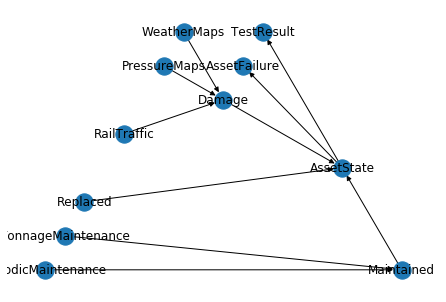

In [5]:
# make the graph
rmdg = nx.DiGraph()
rmdg.add_nodes_from(['PeriodicMaintenance', 'TonnageMaintenance', 'RailTraffic', 'PressureMaps', 'WeatherMaps',
                    'Maintained', 'Replaced', 'Damage',
                   'AssetState', 'AssetFailure', 'TestResult'])
rmdg.add_weighted_edges_from([('PeriodicMaintenance','Maintained', .173792),('TonnageMaintenance','Maintained', .36139), 
                             ('RailTraffic','Damage', .105445), ('PressureMaps', 'Damage', .0093638), ('WeatherMaps', 'Damage', .265303),
                             ('Maintained','AssetState', .0119472), ('Replaced','AssetState', .00808351), ('Damage', 'AssetState', 0.561929),
                             ('AssetState','AssetFailure', .530165), ('AssetState', 'TestResult', 0.812023)])

nx.draw_planar(rmdg, with_labels = True)
nx.is_directed_acyclic_graph(rmdg)

In [6]:
bnodes = [node for node in list(rmdg.nodes()) if not list(rmdg.predecessors(node)) and list(rmdg.successors(node))] #root nodes
observations = [node for node in list(rmdg.nodes()) if not list(rmdg.successors(node)) and list(rmdg.predecessors(node))] #terminal nodes
hypotheses = findHypotheses(rmdg, observations, bnodes)
#is 'Replaced' a bnode or hyp? - a bnode

In [7]:
# learn the CPTable

# PeriodicMaintenance
cpt_PM = CPT(0)
cpt_PM.add_entry_self((1-.7, .7))
rmdg.nodes['PeriodicMaintenance']['CPT'] = cpt_PM

# TonnageMaintenance
cpt_TM = CPT(0)
cpt_TM.add_entry_self((.5, .5))
rmdg.nodes['TonnageMaintenance']['CPT'] = cpt_TM

# RailTraffic - low (0) or high (1)
cpt_RT = CPT(0)
cpt_RT.add_entry_self((1-.8, .8))
rmdg.nodes['RailTraffic']['CPT'] = cpt_RT

# PressureMaps - low (0) or high (1)
cpt_M = CPT(0)
cpt_M.add_entry_self((1-.6, .6))
rmdg.nodes['PressureMaps']['CPT'] = cpt_M

# WeatherMaps - dry (0) or rain(1)
cpt_B = CPT(0)
cpt_B.add_entry_self((.833333, .166667))
rmdg.nodes['WeatherMaps']['CPT'] = cpt_B

# Damage
cpt_D = CPT(3)
cpt_D.add_entry([1, 1, 1], (1-.75, .75))
cpt_D.add_entry([1, 1, 0], (1-.3, .3))
cpt_D.add_entry([1, 0, 1], (1-.45, .45))
cpt_D.add_entry([1, 0, 0], (1-.1, .1))
cpt_D.add_entry([0, 0, 0], (1-.00999999, .00999999))
cpt_D.add_entry([0, 0, 1], (.5, .5))
cpt_D.add_entry([0, 1, 0], (1-.15, .15))
cpt_D.add_entry([0, 1, 1], (1-.6, .6))
rmdg.nodes['Damage']['CPT'] = cpt_D

# Replaced
cpt_R = CPT(0)
cpt_R.add_entry_self((1-.01, .01))
rmdg.nodes['Replaced']['CPT'] = cpt_R

# Maintained
cpt_M = CPT(2)
cpt_M.add_entry([1, 1], (0, 1))
cpt_M.add_entry([1, 0], (1-.6, .6))
cpt_M.add_entry([0, 1], (1-.4, .4))
cpt_M.add_entry([0, 0], (1-.05, .05))
rmdg.nodes['Maintained']['CPT'] = cpt_M

# AssetState - Poor (0) or Good (1)
cpt_AS = CPT(3)
cpt_AS.add_entry([1, 1, 1], (1-.875, .875))
cpt_AS.add_entry([1, 1, 0], (1-.0714286, 0.0714286))
cpt_AS.add_entry([1, 0, 1], (1-0.125, 0.125))
cpt_AS.add_entry([1, 0, 0], (1-0.0105263, 0.0105263))
cpt_AS.add_entry([0, 0, 0], (1-0.833333, 0.833333))
cpt_AS.add_entry([0, 0, 1], (1-0.967742, 0.967742))
cpt_AS.add_entry([0, 1, 0], (1-0.888889, 0.888889))
cpt_AS.add_entry([0, 1, 1], (1-0.994975, 0.994975))
rmdg.nodes['AssetState']['CPT'] = cpt_AS


# AssetFailure
cpt_AF = CPT(1)
cpt_AF.add_entry([1], (1-.1, .1))
cpt_AF.add_entry([0], (1-.9, .9))
rmdg.nodes['AssetFailure']['CPT'] = cpt_AF

# TestResult
cpt_TR = CPT(1)
cpt_TR.add_entry([1], (1-.95, .95))
cpt_TR.add_entry([0], (1-.01, .01))
rmdg.nodes['TestResult']['CPT'] = cpt_TR



In [8]:
fbe1 = get_all_FBE(rmdg, observations, bnodes)
fbe2 = get_all_FBE(rmdg, observations, bnodes, flipped=True)

(['Maintained'], 0.5863095891237967)
(['Damage'], 0.018323235064763747)
(['AssetState'], 0.7338389005706722)
(['Maintained', 'Damage'], 0.010844006723303023)
(['Maintained', 'AssetState'], 0.4517120160725725)
(['Damage', 'AssetState'], 0.0004023441133479146)
(['Maintained', 'Damage', 'AssetState'], 0.00036635173097143757)
(['Maintained'], 0.386464016767189)
(['Damage'], 0.018240085111399785)
(['AssetState'], 0.716161219669796)
(['Maintained', 'Damage'], 0.007147790985989169)
(['Maintained', 'AssetState'], 0.2977444738952609)
(['Damage', 'AssetState'], 0.0002948591089192608)
(['Maintained', 'Damage', 'AssetState'], 0.00024147952570999134)
(['Maintained'], 0.04761110640092982)
(['Damage'], 0.24358687269968948)
(['AssetState'], 0.5300194119525571)
(['Maintained', 'Damage'], 0.011792115761508999)
(['Maintained', 'AssetState'], 0.028491715263519683)
(['Damage', 'AssetState'], 0.0015138512098088826)
(['Maintained', 'Damage', 'AssetState'], 0.000398382455053341)
(['Maintained'], 0.04753185456

In [9]:
truth_dict = get_possible_truths(rmdg, bnodes, observations)
possibly_true = list(truth_dict.keys())
possibly_false = list(truth_dict.values())

In [10]:
# for all possible truth value combinations, columns: True nodes, False nodes (or not), FBE1, probability1, FBE2, probability2
original_data = {}
original_data['True Nodes'] = possibly_true
original_data['False Nodes'] = possibly_false
original_data['Best Explanation'] = [v[0] for v in list(fbe1.values())]
original_data['Prob. of best expl.'] = [v[1] for v in list(fbe1.values())]
original_data['Best Explanation (flipped)'] = [v[0] for v in list(fbe2.values())]
original_data['Prob. of best expl. (flipped)'] = [v[1] for v in list(fbe2.values())]

df1 = pd.DataFrame(original_data, columns=list(original_data.keys()))
df1

,True Nodes,False Nodes,Best Explanation,Prob. of best expl.,Best Explanation (flipped),Prob. of best expl. (flipped)
0,"(PeriodicMaintenance,)","[WeatherMaps, AssetFailure, RailTraffic, Repla...",[AssetState],0.733839,[Damage],0.096458
1,"(TonnageMaintenance,)","[WeatherMaps, AssetFailure, RailTraffic, Repla...",[AssetState],0.716161,[Damage],0.097116
2,"(RailTraffic,)","[WeatherMaps, AssetFailure, Replaced, Pressure...",[AssetState],0.530019,[Damage],0.098267
3,"(PressureMaps,)","[WeatherMaps, AssetFailure, RailTraffic, Repla...",[AssetState],0.581962,[Damage],0.098267
4,"(WeatherMaps,)","[AssetFailure, RailTraffic, Replaced, Pressure...",[Damage],0.645996,[Damage],0.098267
...,...,...,...,...,...,...
250,"(PeriodicMaintenance, TonnageMaintenance, Rail...",[PressureMaps],[Maintained],1.000000,[AssetState],0.095000
251,"(PeriodicMaintenance, TonnageMaintenance, Pres...",[RailTraffic],[Maintained],1.000000,"[Damage, AssetState]",0.095000
252,"(PeriodicMaintenance, RailTraffic, PressureMap...",[TonnageMaintenance],[AssetState],0.956806,"[Maintained, AssetState]",0.095000
253,"(TonnageMaintenance, RailTraffic, PressureMaps...",[PeriodicMaintenance],[AssetState],0.931608,"[Damage, AssetState]",0.095000


# Generate new edges to create a common cause

In [11]:
blockPrint()
fbe1 = get_all_FBE(rmdg, observations, bnodes)

In [12]:
fbe1_result =[tuple(v[0]) for v in list(fbe1.values())]
fbe1_count = dict(Counter(fbe1_result))
    
fbe1_count

{('AssetState',): 117, ('Damage',): 68, ('Maintained',): 70}

### Testing similarity - haven't done anything with it yet.

In [13]:
# generate edges to connect Damage and Maintained (the two parent hypotheses of AssetState) through common parents. 

# calculate similarity between parents of Damage and Maintained - in case this could help us pick where to generate an edge
d_parents = list(rmdg.predecessors('Damage'))
m_parents = list(rmdg.predecessors('Maintained'))

parents_pairs = []
parentsJI, parentsIS, parentsFS = {}, {}, {}
for d in d_parents:
    for m in m_parents:
        parents_pairs.append((d,m)) 
        parentsJI[(d,m)] = calculate_jaccard_similarity(rmdg, d, m)
        parentsIS[(d,m)] = get_immediate_similarity(rmdg, d, m)
        parentsFS[(d,m)] = get_full_similarity(rmdg, d, m)

parentsJI, parentsIS, parentsFS

({('RailTraffic', 'PeriodicMaintenance'): 0.6202087247418423,
  ('RailTraffic', 'TonnageMaintenance'): 0.5711356450910858,
  ('PressureMaps', 'PeriodicMaintenance'): 0.6487581307052916,
  ('PressureMaps', 'TonnageMaintenance'): 0.5952580691615542,
  ('WeatherMaps', 'PeriodicMaintenance'): 0.57789700633148,
  ('WeatherMaps', 'TonnageMaintenance'): 0.5350600005531826},
 {('RailTraffic', 'PeriodicMaintenance'): 1.0,
  ('RailTraffic', 'TonnageMaintenance'): 1.0,
  ('PressureMaps', 'PeriodicMaintenance'): 1.0,
  ('PressureMaps', 'TonnageMaintenance'): 1.0,
  ('WeatherMaps', 'PeriodicMaintenance'): 1.0,
  ('WeatherMaps', 'TonnageMaintenance'): 1.0},
 {('RailTraffic', 'PeriodicMaintenance'): 0.44883881195025,
  ('RailTraffic', 'TonnageMaintenance'): 0.44827849424385,
  ('PressureMaps', 'PeriodicMaintenance'): 0.43534110879155,
  ('PressureMaps', 'TonnageMaintenance'): 0.43478079108515,
  ('WeatherMaps', 'PeriodicMaintenance'): 0.47129602347075,
  ('WeatherMaps', 'TonnageMaintenance'): 0.47073

In [14]:
max_JI = max(parentsJI, key=parentsJI.get)
max_IS = max(parentsIS, key=parentsIS.get)
max_FS = max(parentsFS, key=parentsFS.get)

max_JI, max_IS, max_FS

(('PressureMaps', 'PeriodicMaintenance'),
 ('RailTraffic', 'PeriodicMaintenance'),
 ('WeatherMaps', 'PeriodicMaintenance'))

In [15]:
parents_pairs = []
parentsJI, parentsIS, parentsFS = {}, {}, {}
for m in m_parents:
    for d in d_parents:
        parents_pairs.append((d,m)) 
        parentsJI[(m,d)] = calculate_jaccard_similarity(rmdg, m,d)
        parentsIS[(m,d)] = get_immediate_similarity(rmdg, m,d)
        parentsFS[(m,d)] = get_full_similarity(rmdg, m,d)

max_JI = max(parentsJI, key=parentsJI.get)
max_IS = max(parentsIS, key=parentsIS.get)
max_FS = max(parentsFS, key=parentsFS.get)

max_JI, max_IS, max_FS

(('PeriodicMaintenance', 'PressureMaps'),
 ('PeriodicMaintenance', 'RailTraffic'),
 ('PeriodicMaintenance', 'WeatherMaps'))

True

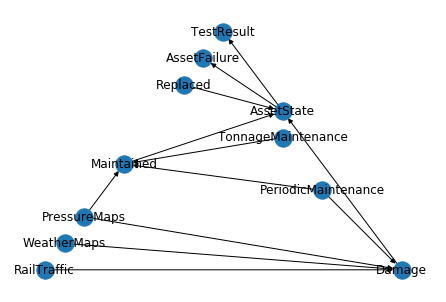

In [16]:
# Generate edges (RailTraffic, Maintained) and (PeriodicMaintenance, Damage)
rmdg.add_weighted_edges_from([('PressureMaps', 'Maintained', .0869213), 
                             ('PeriodicMaintenance', 'Damage', .104758)])

nx.draw_planar(rmdg, with_labels=True)
nx.is_directed_acyclic_graph(rmdg)

In [17]:
# Learn updated CPT 


# Damage
cpt_D = CPT(4)
cpt_D.add_entry([0, 0, 0, 0], (1-.897361, .897361))
cpt_D.add_entry([0, 0, 0, 1], (1-0.0864661, .0864661))
cpt_D.add_entry([0, 0, 1, 0], (1-0.452449, .452449))
cpt_D.add_entry([0, 0, 1, 1], (1-0.523823, 0.523823))
cpt_D.add_entry([0, 1, 0, 0], (1-0.525793, 0.525793))
cpt_D.add_entry([0, 1, 0, 1], (1-0.02309, 0.02309))
cpt_D.add_entry([0, 1, 1, 0], (1-0.55044, 0.55044))
cpt_D.add_entry([0, 1, 1, 1], (1-0.443666, 0.443666))
cpt_D.add_entry([1, 0, 0, 0], (1-0.1, 0.504956))
cpt_D.add_entry([1, 0, 0, 1], (1-0.755279, 0.755279))
cpt_D.add_entry([1, 0, 1, 0], (1-0.48401, 0.48401))
cpt_D.add_entry([1, 0, 1, 1], (1-0.0426066, 0.0426066))
cpt_D.add_entry([1, 1, 0, 0], (1-0.415878, 0.415878))
cpt_D.add_entry([1, 1, 0, 1], (1-0.48176, 0.48176))
cpt_D.add_entry([1, 1, 1, 0], (1-0.722924, 0.722924))
cpt_D.add_entry([1, 1, 1, 1], (1-0.24392, .24392))
rmdg.nodes['Damage']['CPT'] = cpt_D


# Maintained
cpt_M = CPT(3)
cpt_M.add_entry([0, 0, 0], (1-.857672, .857672))
cpt_M.add_entry([0, 0, 1], (1-.751924, .751924))
cpt_M.add_entry([0, 1, 0], (1-.507768, 507768))
cpt_M.add_entry([0, 1, 1], (1-.119625, .119625))
cpt_M.add_entry([1, 0, 0], (1-.372849, .372849))
cpt_M.add_entry([1, 0, 1], (1-.872817, .872817))
cpt_M.add_entry([1, 1, 0], (1-.844437, 844437))
cpt_M.add_entry([1, 1, 1], (1-498706, .498706))
rmdg.nodes['Maintained']['CPT'] = cpt_M

# AssetState - Poor (0) or Good (1)
cpt_AS = CPT(3)
cpt_AS.add_entry([0,1,1], (1-0.0305111, 0.0305111))
cpt_AS.add_entry([0,1,0], (1-0.585991, 0.585991))
cpt_AS.add_entry([0,0,1], (1-0.234251, 0.234251))
cpt_AS.add_entry([0,0,0], (1-0.334416, 0.334416))
cpt_AS.add_entry([1,1,1], (1-0.60196, 0.60196))
cpt_AS.add_entry([1,1,0], (1-0.732915, 0.732915))
cpt_AS.add_entry([1,0,1], (1-0.916999, .916999))
cpt_AS.add_entry([1,0,0], (1-.753021, 0.753021))
rmdg.nodes['AssetState']['CPT'] = cpt_AS


# TestResult
cpt_TR = CPT(1)
cpt_TR.add_entry([0], (1-.955432, .955432))
cpt_TR.add_entry([1], (1-.522981, .522981))
rmdg.nodes['TestResult']['CPT'] = cpt_TR


# AssetFailure
cpt_AF = CPT(1)
cpt_AF.add_entry([0], (1-.249014, .249014))
cpt_AF.add_entry([1], (1-.566034, .566034))
rmdg.nodes['AssetFailure']['CPT'] = cpt_AF


# Export data

In [18]:
bnodes = [node for node in list(rmdg.nodes()) if not list(rmdg.predecessors(node)) and list(rmdg.successors(node))] #root nodes
observations = [node for node in list(rmdg.nodes()) if not list(rmdg.successors(node)) and list(rmdg.predecessors(node))] #terminal nodes
hypotheses = findHypotheses(rmdg, observations, bnodes)

In [19]:
blockPrint()
fbe1_new = get_all_FBE(rmdg, observations, bnodes)
fbe2_new = get_all_FBE(rmdg, observations, bnodes, flipped=True)

In [20]:
truth_dict = get_possible_truths(rmdg, bnodes, observations)
possibly_true = list(truth_dict.keys())
possibly_false = list(truth_dict.values())

In [21]:
# for all possible truth value combinations, columns: True nodes, False nodes (or not), FBE1, probability1, FBE2, probability2
new_data = {}
new_data['True Nodes'] = possibly_true
new_data['False Nodes'] = possibly_false
new_data['Best Explanation'] = [v[0] for v in list(fbe1_new.values())]
new_data['Prob. of best expl.'] = [v[1] for v in list(fbe1_new.values())]
new_data['Best Explanation (flipped)'] = [v[0] for v in list(fbe2_new.values())]
new_data['Prob. of best expl. (flipped)'] = [v[1] for v in list(fbe2_new.values())]

df2 = pd.DataFrame(new_data, columns=list(new_data.keys()))
df2

,True Nodes,False Nodes,Best Explanation,Prob. of best expl.,Best Explanation (flipped),Prob. of best expl. (flipped)
0,"(PeriodicMaintenance,)","[WeatherMaps, AssetFailure, RailTraffic, Repla...",[AssetState],0.879908,"[Maintained, AssetState]",0.207010
1,"(TonnageMaintenance,)","[WeatherMaps, AssetFailure, RailTraffic, Repla...",[AssetState],0.939707,"[Maintained, AssetState]",0.207010
2,"(RailTraffic,)","[WeatherMaps, AssetFailure, Replaced, Pressure...",[AssetState],0.914683,"[Maintained, Damage, AssetState]",0.207010
3,"(PressureMaps,)","[WeatherMaps, AssetFailure, RailTraffic, Repla...",[Maintained],0.999999,"[Maintained, AssetState]",0.207010
4,"(WeatherMaps,)","[AssetFailure, RailTraffic, Replaced, Pressure...",[Maintained],0.894350,[AssetState],0.207010
...,...,...,...,...,...,...
250,"(PeriodicMaintenance, TonnageMaintenance, Rail...",[PressureMaps],[Maintained],0.867275,"[Damage, AssetState]",0.296025
251,"(PeriodicMaintenance, TonnageMaintenance, Pres...",[RailTraffic],[AssetState],0.615992,[AssetState],0.296025
252,"(PeriodicMaintenance, RailTraffic, PressureMap...",[TonnageMaintenance],[Maintained],1.000000,"[Maintained, AssetState]",0.296025
253,"(TonnageMaintenance, RailTraffic, PressureMaps...",[PeriodicMaintenance],[AssetState],0.561207,"[Maintained, Damage, AssetState]",0.296025


In [25]:
# data to Excel
with pd.ExcelWriter(r'C:\Users\hanaa\OneDrive\amistad 2020\figures\rail-maintenance-data.xlsx') as writer:  
    df1.to_excel(writer, sheet_name='Before Edge Generation')
    df2.to_excel(writer, sheet_name='After Edge Generation')

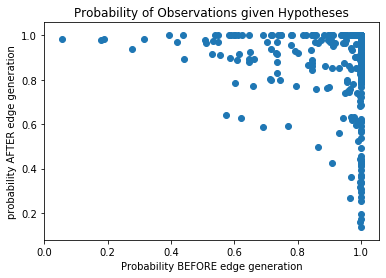

In [23]:
# bar chart to probabilities of best explanations before and after generating edges
plt.scatter([v[1] for v in list(fbe1.values())], [v[1] for v in list(fbe1_new.values())])
plt.ylabel('probability AFTER edge generation')
plt.xlabel('Probability BEFORE edge generation')
plt.title('Probability of Observations given Hypotheses')
plt.show()
plt.close()

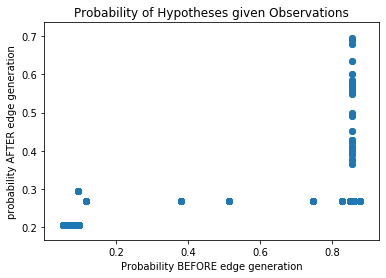

In [24]:
# bar chart to probabilities of best explanations before and after generating edges
plt.scatter([v[1] for v in list(fbe2.values())], [v[1] for v in list(fbe2_new.values())])
plt.ylabel('probability AFTER edge generation')
plt.xlabel('Probability BEFORE edge generation')
plt.title('Probability of Hypotheses given Observations')
plt.show()
plt.close()